/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Round: 0, Q: 103.0
Round: 1, Q: 395.0
Round: 2, Q: 554.0
Round: 3, Q: 557.0
Round: 4, Q: 550.0
Round: 5, Q: 692.0
Round: 6, Q: 450.0
Round: 7, Q: 583.0
Round: 8, Q: 363.0
Round: 9, Q: 355.0
Round: 10, Q: 303.0
Round: 11, Q: 319.0
Round: 12, Q: 434.0
Round: 13, Q: 372.0
Round: 14, Q: 313.0
Round: 15, Q: 538.0
Round: 16, Q: 399.0
Round: 17, Q: 400.0
Round: 18, Q: 445.0
Round: 19, Q: 491.0
Round: 20, Q: 399.0
Round: 21, Q: 368.0
Round: 22, Q: 329.0
Round: 23, Q: 430.0
Round: 24, Q: 352.0
Round: 25, Q: 319.0
Round: 26, Q: 300.0
Round: 27, Q: 356.0
Round: 28, Q: 354.0
Round: 29, Q: 418.0
Round: 30, Q: 351.0
Round: 31, Q: 354.0
Round: 32, Q: 429.0
Round: 33, Q: 355.0
Round: 34, Q: 312.0
Round: 35, Q: 345.0
Round: 36, Q: 379.0
Round: 37, Q: 362.0
Round: 38, Q: 342.0
Round: 39, Q: 378.0
Round: 40, Q: 349.0
Round: 41, Q: 445.0
Round: 42, Q: 417.0
Round: 43, Q: 477.0
Round: 44, Q: 508.0
Round: 45, Q: 303.0
Round: 46, Q: 334.0
Round: 47, Q: 390.0
Round: 48, Q: 398.0
Round: 49, Q: 452.0
Round: 50,

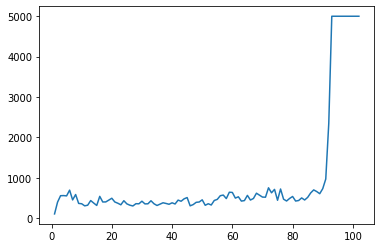

In [13]:


import gym
import random
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output

clear_output()
env = gym.make('CartPole-v0')
env._max_episode_steps = 5000

alpha = 0.05
gamma = 0.99
nu_of_rollouts = 10
len_of_rollouts = 500

epsilon = 1.

def sigmoid(x):
    return 0 if x<-30 else (1 if x>30 else 1.0/(1+math.exp(-x)) )

def sigmoid_der(x):
    return sigmoid(x) * (1 - sigmoid(x))

sigmoid = np.vectorize(sigmoid)
sigmoid_der = np.vectorize(sigmoid)

def discount_rewards(r):
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, r.size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

theta = np.random.rand(5)  # Policy Gradient Network
theta_res = None

def arrange_state(state):
    return np.append(state,1)

Q_values = []
theta_update = []

for i_episode in range(200):

    # initialize matrice for gradients and rewards for 10 rollout with length 500
    grad_mat = np.zeros((nu_of_rollouts, len_of_rollouts, 5))
    rew_mat = np.zeros((nu_of_rollouts, len_of_rollouts))

    Q = 0

    # decrease randomization parameter
    epsilon *= 0.975 # 0.975 is like make epsilon half in 25 step, so make k = 2 in about 25 step

    for i in range(nu_of_rollouts):

        s_t = env.reset()
        s_t = arrange_state(s_t)

        for j in range(len_of_rollouts):

            # k makes distribution escape from mean, 
            # it means if k=2 and p = 0.65, new p is 0.65 + (2-1) * (0.65-0.5) = 0.8
            # and if k=3 and p = 0.4, new p is 0.4 - (3-1) * (0.5-0.4) = 0.2
            # on the other han, changed k different from 1 effects the gradient.
            k = 2

            # find next action probabistically, when time passed, random selections are decreased
            p = k*sigmoid(theta.dot(s_t))-(k-1)*0.5
            a_t = 0 if random.random()>p else 1

            s_t_plus_one, reward, done, info = env.step(a_t)
            s_t_plus_one = arrange_state(s_t_plus_one)

            Q += reward

            # rewards and gradients  are calculated
            rew_mat[i, j] = reward
            grad_mat[i, j] = (a_t*(1-p/k)+(a_t-1)*p/k)*s_t

            s_t = s_t_plus_one

        # discounted reward is calculated for ith rollouts rewards
        rew_mat[i] = discount_rewards(rew_mat[i])

        env.close()

    # 10 rollout with length 500 is passed now, calculate new theta
    rew_mat -= np.mean(rew_mat)   # average of discounted rewards are subracted from all discounted rewards
    rew_mat /= np.std(rew_mat)

    # calculate new theta after an episode with 10 rollouts with length 500
    for i in range(nu_of_rollouts):

        sum_causality = np.zeros(5)

        for j in range(len_of_rollouts):
            sum_causality  += grad_mat[i, j] * rew_mat[i, j] # causality performs here

        theta += alpha * sum_causality / nu_of_rollouts      # backpropagation for one of ten rollouts

    print("Round: "+i_episode.__str__() + ", Q: "+Q.__str__())
    Q_values += [Q]

    # if last 10 episodes are fully finished with done, break
    if len(Q_values) > 10:
        ok = True
        for i in range(len(Q_values)-10, len(Q_values)):
            if Q_values[i] != nu_of_rollouts*len_of_rollouts:
                ok = False
                break
        if ok:
            theta_res = np.copy(theta)
            break

plt.plot(range(1, len(Q_values)+1), Q_values)
plt.show()

Round: 0, Q: 50000.0


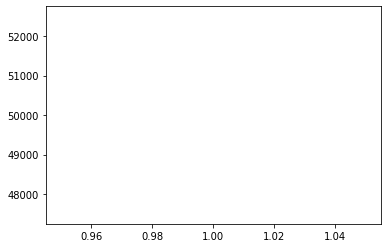

In [17]:
try:
    theta_res
    sigmoid(theta_res.dot(np.zeros(5)))
except:
    print("Please run training code one more time")

#this code was for testing, It runs environment for 100 times, and plots how many step it goes.

env._max_episode_steps = 50000

Q_values = []

for i_episode in range(1):
    
    s_t = env.reset()
    s_t = arrange_state(s_t)

    Q = 0
    
    while True:
        
        env.render()
    
        p = sigmoid(theta_res.dot(s_t))
        
        a_t = 0 if 0.5>p else 1

        s_t_plus_one, reward, done, info = env.step(a_t)
        s_t_plus_one = arrange_state(s_t_plus_one)
    
        Q += reward
        
        if done:
            break

        s_t = s_t_plus_one
        
    print("Round: "+i_episode.__str__() + ", Q: "+Q.__str__())
    Q_values += [Q]

    env.close()
    
plt.plot(range(1, len(Q_values)+1), Q_values)
plt.show()